In [1]:
from misc import HP
import argparse
import random
import time
import pickle
import copy
import SYCLOP_env as syc
from misc import *
import sys
import os
import cv2
import argparse
import tensorflow.keras as keras

from keras_networks import rnn_model_102, rnn_model_multicore_201, rnn_model_multicore_202
from curriculum_utils import create_mnist_dataset, bad_res102

In [6]:

def generate_trajectory(n_steps,max_q,acceleration_mode):
    starting_point = np.array([max_q[0] // 2, max_q[1] // 2])
    steps = []
    qdot=0
    for j in range(n_steps):
        steps.append(starting_point * 1)
        if acceleration_mode:
            qdot += np.random.randint(-1, 2, 2)
            starting_point += qdot
        else:
            starting_point += np.random.randint(-5, 6, 2)
    return np.array(steps)

In [30]:
def split_dataset_xy(dataset):
    dataset_x1 = [uu[0] for uu in dataset]
    dataset_x2 = [uu[1] for uu in dataset]
    dataset_y = [uu[-1] for uu in dataset]
    return (np.array(dataset_x1)[...,np.newaxis],np.array(dataset_x2)[:,:n_timesteps,:]),np.array(dataset_y)

#parse hyperparameters

lsbjob = os.getenv('LSB_JOBID')
lsbjob = '' if lsbjob is None else lsbjob

hp = HP()
hp.save_path = 'saved_runs'
hp.description=''
parser = argparse.ArgumentParser()
parser.add_argument('--tau_int', default=4., type=float, help='Integration timescale for adaaptation')
parser.add_argument('--resize', default=1.0, type=float, help='resize of images')
parser.add_argument('--run_name_suffix', default='', type=str, help='suffix for runname')
parser.add_argument('--eval_dir', default=None, type=str, help='eval dir')

parser.add_argument('--dqn_initial_network', default=None, type=str, help='dqn_initial_network')
parser.add_argument('--decoder_initial_network', default=None, type=str, help='decoder_initial_network')
parser.add_argument('--decoder_arch', default='default', type=str, help='decoder_network architecture: default / multicore_201')
parser.add_argument('--decoder_n_cores',  default=1, type=int, help='decoder number of cores')

parser.add_argument('--decoder_learning_rate',  default=1e-3, type=float, help='decoder learning rate')
parser.add_argument('--decoder_dropout',  default=0.0, type=float, help='decoder dropout')
parser.add_argument('--decoder_rnn_type',  default='gru', type=str, help='gru or rnn')
parser.add_argument('--decoder_rnn_units',  default=100, type=int, help='decoder rnn units')
parser.add_argument('--decoder_rnn_layers',  default=1, type=int, help='decoder rnn units')


parser.add_argument('--decoder_ignore_position', dest='decoder_ignore_position', action='store_true')
parser.add_argument('--no-decoder_ignore_position', dest='decoder_ignore_position', action='store_false')

parser.add_argument('--syclop_learning_rate',  default=2.5e-3, type=float, help='syclop (RL) learning rate')

parser.add_argument('--color', default='grayscale', type=str, help='grayscale/rgb')
parser.add_argument('--speed_reward',  default=0.0, type=float, help='speed reward, typically negative')
parser.add_argument('--intensity_reward',  default=0.0, type=float, help='speed penalty reward')
parser.add_argument('--loss_reward',  default=-1.0, type=float, help='reward for loss, typically negative')
parser.add_argument('--resolution',  default=28, type=int, help='resolution')
parser.add_argument('--max_eval_episodes',  default=10000, type=int, help='episodes for evaluation mode')
parser.add_argument('--steps_per_episode',  default=9, type=int, help='time steps in each episode in ')
parser.add_argument('--fit_verbose',  default=1, type=int, help='verbose level for model.fit                        ')
parser.add_argument('--steps_between_learnings',  default=100, type=int, help='steps_between_learnings')
parser.add_argument('--num_epochs',  default=100, type=int, help='steps_between_learnings')

parser.add_argument('--alpha_increment',  default=0.01, type=float, help='reward for loss, typically negative')


parser.add_argument('--beta_t1',  default=400000, type=int, help='time rising bete')
parser.add_argument('--beta_t2',  default=700000, type=int, help='end rising beta')
parser.add_argument('--beta_b1',  default=0.1, type=float, help='beta initial value')
parser.add_argument('--beta_b2',  default=1.0, type=float, help='beta final value')

parser.add_argument('--curriculum_enable', dest='curriculum_enable', action='store_true')
parser.add_argument('--no-curriculum_enable', dest='curriculum_enable', action='store_false')

parser.add_argument('--conv_fe', dest='conv_fe', action='store_true')
parser.add_argument('--no-conv_fe', dest='conv_fe', action='store_false')

parser.add_argument('--acceleration_mode', dest='acceleration_mode', action='store_true')
parser.add_argument('--no-acceleration_mode', dest='acceleration_mode', action='store_false')


parser.set_defaults(eval_mode=False, decode_from_dvs=False,test_mode=False,rising_beta_schedule=True,decoder_ignore_position=False, curriculum_enable=True, conv_fe=False,
                    acceleration_mode=True)
config = parser.parse_args('')

# config = parser.parse_args()
config = vars(config)
hp.upadte_from_dict(config)
hp.this_run_name = sys.argv[0] + '_noname_' + hp.run_name_suffix + '_' + lsbjob + '_' + str(int(time.time()))

#define model
n_timesteps = hp.steps_per_episode

##
# deploy_logs()
##
# if hp.decoder_arch == 'multicore_201':
#     decoder = rnn_model_multicore_201(n_cores=hp.decoder_n_cores,lr=hp.decoder_learning_rate,ignore_input_B=hp.decoder_ignore_position,dropout=hp.decoder_dropout,rnn_type=hp.decoder_rnn_type,
#                                 input_size=(hp.resolution,hp.resolution, 1),rnn_layers=hp.decoder_rnn_layers,conv_fe=hp.conv_fe, rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
# if hp.decoder_arch == 'multicore_202':
#     decoder = rnn_model_multicore_202(n_cores=hp.decoder_n_cores, lr=hp.decoder_learning_rate,
#                                       ignore_input_B=hp.decoder_ignore_position, dropout=hp.decoder_dropout,
#                                       rnn_type=hp.decoder_rnn_type,
#                                       input_size=(hp.resolution, hp.resolution, 1),
#                                       rnn_layers=hp.decoder_rnn_layers, conv_fe=hp.conv_fe,
#                                       rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
# elif hp.decoder_arch == 'default':
#     decoder = rnn_model_102(lr=hp.decoder_learning_rate,ignore_input_B=hp.decoder_ignore_position,dropout=hp.decoder_dropout,rnn_type=hp.decoder_rnn_type,
#                                 input_size=(hp.resolution,hp.resolution, 1),rnn_layers=hp.decoder_rnn_layers,conv_fe=hp.conv_fe,rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
decoder_initial_network = 'saved_runs/trajectory_curriculum101.py_noname__200012_1624129553_1/final_decoder.nwk'
decoder = keras.models.load_model(decoder_initial_network)
    #define dataset
(images, labels), (images_test, labels_test) = keras.datasets.mnist.load_data(path="mnist.npz")


#fit one epoch in a  time
# scheduler = Scheduler(hp.lambda_schedule)
# for epoch in range(hp.num_epochs):
#     lambda_epoch = scheduler.step(epoch)

In [31]:
hp.acceleration_mode

True

In [91]:
alpha=0
hp.num_trials = 30
# trajectories = []
train_pred_pred = []
val_pred_pred = []
for trial in range(hp.num_trials):
#     this_trajectory=generate_trajectory(hp.steps_per_episode,[72,72],hp.acceleration_mode)
    this_trajectory=trajectories[trial]
    train_dataset, test_dataset = create_mnist_dataset(images, labels, 6, sample=hp.steps_per_episode, bad_res_func=bad_res102,
                                                           return_datasets=True, q_0=this_trajectory, alpha=0.0,
                                                           random_trajectories=True,acceleration_mode=hp.acceleration_mode)
    train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset)
    test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset)
    q_prime = train_dataset_x[1][0]
#     print('epoch', epoch, '  CONTROL!!!',' first q --', q_prime.reshape([-1]))

    print("evaluating trajectory  ", trial)
    train_preds = decoder.predict(
        train_dataset_x,
        batch_size=64,
        verbose=hp.fit_verbose,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        )
    val_preds = decoder.predict(
        test_dataset_x,
        batch_size=64,
        verbose=hp.fit_verbose,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        )
    accuracy =  np.mean(np.argmax(val_preds, axis=1)==test_dataset_y)
    print('accuracy:', accuracy)
#     trajectories.append(this_trajectory+0.)
    train_pred_pred.append(train_preds+0.0)
    val_pred_pred.append(val_preds+0.0)

Are we random? 8
evaluating trajectory   0
5000/5000 [==============================] - 2s 412us/sample
accuracy: 0.8198
Are we random? 13
evaluating trajectory   1
5000/5000 [==============================] - 2s 424us/sample
accuracy: 0.8732
Are we random? 18
evaluating trajectory   2
5000/5000 [==============================] - 2s 413us/sample
accuracy: 0.8654
Are we random? 1
evaluating trajectory   3
5000/5000 [==============================] - 2s 415us/sample
accuracy: 0.8316
Are we random? 7
evaluating trajectory   4
5000/5000 [==============================] - 2s 408us/sample
accuracy: 0.8712
Are we random? 4
evaluating trajectory   5
5000/5000 [==============================] - 2s 404us/sample
accuracy: 0.8718
Are we random? 2
evaluating trajectory   6
5000/5000 [==============================] - 2s 413us/sample
accuracy: 0.8754
Are we random? 19
evaluating trajectory   7
5000/5000 [==============================] - 2s 406us/sample
accuracy: 0.8258
Are we random? 18
evaluating 

In [23]:
accuracy =  np.mean(np.argmax(preds, axis=1)==test_dataset_y)

In [24]:
accuracy

0.7278

In [40]:
ent = np.zeros([np.shape(test_dataset_y)[0],hp.num_trials])
lablab = np.zeros([np.shape(test_dataset_y)[0],hp.num_trials])
for jj,preds in enumerate(pred_pred):
    ent[:,jj]=np.sum(-preds*np.log(preds),axis=1)
    lablab[:,jj]=np.argmax(preds, axis=1)

In [50]:
ii=np.argmin(ent,axis=1)

In [71]:
best_lbl=[]
for jj,uu in enumerate(ii):
    best_lbl.append(lablab[jj,uu])


In [73]:
np.mean(best_lbl==test_dataset_y)

0.9106

In [58]:
np.mean(lablab==test_dataset_y.reshape([-1,1]))

0.8463933333333333

In [130]:
accuracies=np.mean(lablab==test_dataset_y.reshape([-1,1]),axis=0)

In [63]:
best_ii=np.argmax(np.mean(lablab==test_dataset_y.reshape([-1,1]),axis=0))

In [65]:
np.mean(ii==best_ii)

0.0772

In [70]:
np.mean(np.any(lablab==test_dataset_y.reshape([-1,1]),axis=1))

0.9932

In [74]:
best_ent=np.min(ent,axis=1)

(array([3.054e+03, 7.410e+02, 3.950e+02, 2.450e+02, 1.690e+02, 1.170e+02,
        9.000e+01, 6.600e+01, 3.500e+01, 3.100e+01, 2.000e+01, 1.300e+01,
        1.200e+01, 5.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.0018796 , 0.05121257, 0.10054555, 0.14987852, 0.19921149,
        0.24854446, 0.29787743, 0.34721041, 0.39654338, 0.44587635,
        0.49520932, 0.54454229, 0.59387527, 0.64320824, 0.69254121,
        0.74187418, 0.79120715, 0.84054012, 0.8898731 , 0.93920607,
        0.98853904]),
 <a list of 20 Patch objects>)

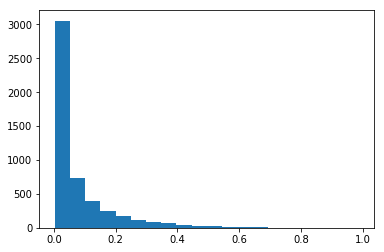

In [77]:
_=plt.hist(best_ent,bins=20)

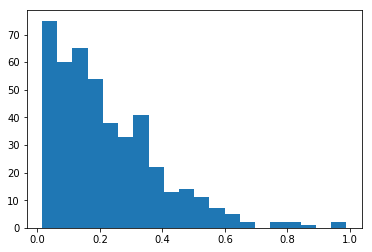

In [78]:
_=plt.hist(best_ent[best_lbl!=test_dataset_y],bins=20)

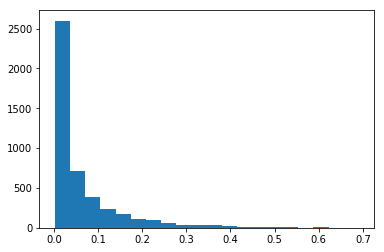

In [79]:
_=plt.hist(best_ent[best_lbl==test_dataset_y],bins=20)

In [85]:
super_pred=np.sum(pred_pred,axis=0)

In [86]:
super_label=np.argmax(super_pred,axis=1)

In [87]:
np.mean(super_label==test_dataset_y)

0.942

In [84]:
super_label.shape

(30,)

In [88]:
with open('committee103_traj_30.pkl','wb') as f:
    pickle.dump(trajectories,f)

In [90]:
trajectories

[array([[36., 36.],
        [36., 36.],
        [36., 36.],
        [35., 35.],
        [35., 34.],
        [34., 34.],
        [34., 35.],
        [33., 37.],
        [31., 38.]]), array([[36., 36.],
        [37., 37.],
        [39., 39.],
        [41., 40.],
        [43., 40.],
        [46., 40.],
        [49., 39.],
        [53., 38.],
        [58., 37.]]), array([[36., 36.],
        [35., 36.],
        [33., 35.],
        [30., 34.],
        [28., 32.],
        [25., 30.],
        [21., 29.],
        [18., 27.],
        [15., 24.]]), array([[36., 36.],
        [35., 35.],
        [35., 34.],
        [36., 32.],
        [38., 29.],
        [40., 25.],
        [43., 21.],
        [47., 18.],
        [50., 15.]]), array([[36., 36.],
        [36., 37.],
        [37., 39.],
        [38., 41.],
        [39., 44.],
        [40., 46.],
        [40., 48.],
        [39., 50.],
        [39., 51.]]), array([[36., 36.],
        [35., 37.],
        [33., 38.],
        [31., 38.],
        [30., 3

In [92]:
trajectories[25]

array([[36., 36.],
       [37., 35.],
       [37., 34.],
       [38., 32.],
       [40., 31.],
       [42., 30.],
       [43., 29.],
       [44., 28.],
       [46., 27.]])

In [105]:
def super_pred_fun(pred,T=1):
    logits = np.log(pred)
    pred_T = np.exp(1./T*logits)
    pred_T = pred_T/np.sum(pred_T,axis=-1)[...,np.newaxis]
    super_pred=np.sum(pred_T,axis=0)
    return super_pred

In [106]:
super_pred = super_pred_fun(train_pred_pred)

In [114]:
super_pred = super_pred_fun(val_pred_pred,T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.9448


In [109]:
np.linspace(0.1,5.0,100)

array([0.1       , 0.14949495, 0.1989899 , 0.24848485, 0.2979798 ,
       0.34747475, 0.3969697 , 0.44646465, 0.4959596 , 0.54545455,
       0.59494949, 0.64444444, 0.69393939, 0.74343434, 0.79292929,
       0.84242424, 0.89191919, 0.94141414, 0.99090909, 1.04040404,
       1.08989899, 1.13939394, 1.18888889, 1.23838384, 1.28787879,
       1.33737374, 1.38686869, 1.43636364, 1.48585859, 1.53535354,
       1.58484848, 1.63434343, 1.68383838, 1.73333333, 1.78282828,
       1.83232323, 1.88181818, 1.93131313, 1.98080808, 2.03030303,
       2.07979798, 2.12929293, 2.17878788, 2.22828283, 2.27777778,
       2.32727273, 2.37676768, 2.42626263, 2.47575758, 2.52525253,
       2.57474747, 2.62424242, 2.67373737, 2.72323232, 2.77272727,
       2.82222222, 2.87171717, 2.92121212, 2.97070707, 3.02020202,
       3.06969697, 3.11919192, 3.16868687, 3.21818182, 3.26767677,
       3.31717172, 3.36666667, 3.41616162, 3.46565657, 3.51515152,
       3.56464646, 3.61414141, 3.66363636, 3.71313131, 3.76262

In [115]:
super_pred = super_pred_fun(val_pred_pred[:15],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.9434


In [116]:
super_pred = super_pred_fun(val_pred_pred[:5],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.9348


In [122]:
super_pred = super_pred_fun(val_pred_pred[:2],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.908


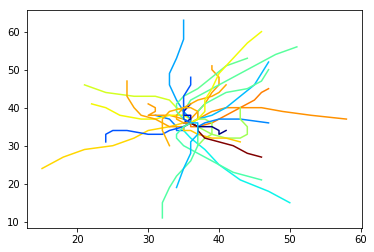

In [133]:
# x = np.linspace(0, 2*np.pi, 64)
# y = np.cos(x) 

# pl.figure()
# pl.plot(x,y)

n = hp.num_trials
# colors = plt.cm.jet(accuracies)
colors = plt.cm.jet((accuracies-np.min(accuracies))/(np.max(accuracies)-np.min(accuracies)))
# 
for trial in range(hp.num_trials):
    plt.plot(trajectories[trial][:,0],trajectories[trial][:,1],  color=colors[trial])
# plt.colorbar()

In [ ]:
colors = plt.cm.jet((accuracies-np.min(accuracies))/(np.max(accuracies)-np.min(accuracies)))

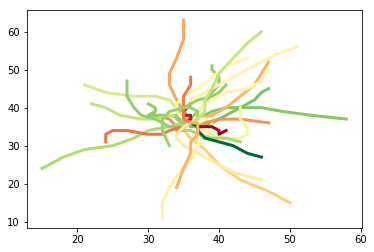

In [137]:
n = hp.num_trials
# colors = plt.cm.jet(accuracies)
colors = plt.cm.RdYlGn((accuracies-np.min(accuracies))/(np.max(accuracies)-np.min(accuracies)))
# 
for trial in range(hp.num_trials):
    plt.plot(trajectories[trial][:,0],trajectories[trial][:,1],  color=colors[trial],linewidth=3)

In [128]:
plt.cm.jet(1.0)

(0.5, 0.0, 0.0, 1.0)

In [ ]:
n_lines = hp.num_trials
x = np.arange(100)

yint = np.arange(0, n_lines*10, 10)
ys = np.array([x + b for b in yint])
xs = np.array([x for i in range(n_lines)]) # could also use np.tile

colors = np.arange(n_lines)

fig, ax = plt.subplots()
lc = multiline(xs, ys, yint, cmap='bwr', lw=2)

axcb = fig.colorbar(lc)
axcb.set_label('Y-intercept')
ax.set_title('Line Collection with mapped colors')

In [140]:
# Set the input shape
input_shape = (50,)
# print(f'Feature shape: {input_shape}')

# Create the model
model = keras.Sequential()
model.add(keras.layers.Dense(300, input_shape=input_shape, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(100,  activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation='softmax'))

# Configure the model and start training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(np.transpose(train_pred_pred[:5],[1,2,0]).reshape([-1,50]), train_dataset_y.astype(int), epochs=100, batch_size=250, verbose=1, validation_split=0.2)


Train on 44000 samples, validate on 11000 samples
Epoch 1/100
44000/44000 [==============================] - 3s 79us/sample - loss: 0.5499 - acc: 0.8665 - val_loss: 0.2493 - val_acc: 0.9312
Epoch 2/100
44000/44000 [==============================] - 2s 37us/sample - loss: 0.2773 - acc: 0.9298 - val_loss: 0.2411 - val_acc: 0.9314
Epoch 3/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.2632 - acc: 0.9321 - val_loss: 0.2346 - val_acc: 0.9319
Epoch 4/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.2523 - acc: 0.9337 - val_loss: 0.2316 - val_acc: 0.9326
Epoch 5/100
44000/44000 [==============================] - 2s 39us/sample - loss: 0.2448 - acc: 0.9347 - val_loss: 0.2293 - val_acc: 0.9323
Epoch 6/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.2423 - acc: 0.9353 - val_loss: 0.2242 - val_acc: 0.9332
Epoch 7/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.2357 - acc: 0.9365 - val_l

Epoch 59/100
44000/44000 [==============================] - 2s 39us/sample - loss: 0.1578 - acc: 0.9525 - val_loss: 0.2115 - val_acc: 0.9362
Epoch 60/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.1550 - acc: 0.9527 - val_loss: 0.2125 - val_acc: 0.9368
Epoch 61/100
44000/44000 [==============================] - 2s 39us/sample - loss: 0.1565 - acc: 0.9530 - val_loss: 0.2110 - val_acc: 0.9370
Epoch 62/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.1560 - acc: 0.9523 - val_loss: 0.2116 - val_acc: 0.9350
Epoch 63/100
44000/44000 [==============================] - 2s 39us/sample - loss: 0.1548 - acc: 0.9528 - val_loss: 0.2146 - val_acc: 0.9363
Epoch 64/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.1554 - acc: 0.9525 - val_loss: 0.2107 - val_acc: 0.9365
Epoch 65/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.1520 - acc: 0.9540 - val_loss: 0.2119 - val_acc: 0.9357
Epoch 66/100
